In [1]:
import polars as pl
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1hb_ua0c because the default path (/home/work/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# データセット

## データ読込

In [2]:
data ="./Data/economicdata.xls"
df = pd.read_excel(data)
df = pl.from_pandas(df).rename({"Unnamed: 0": "Date"}).with_columns(pl.col("Date").cast(pl.Date))

## 特徴量

In [3]:
labels = ["topix","exrate","indprod"]

for idx, label in enumerate(labels):    
    to_label = f"{label}_log_diff"
    if to_label not in df.columns:
        df = df.with_column(pl.col(label).log().diff().alias(to_label))

/tmp/ipykernel_6622/617021615.py:6: DeprecationWarning: `with_column` has been deprecated in favor of `with_columns`. This method will be removed in version 0.17.0
  df = df.with_column(pl.col(label).log().diff().alias(to_label))


## 2.5

In [4]:
to_label = f"indprod_log_diff"

## (a) 標本自己相関

(-0.5, 0.5)

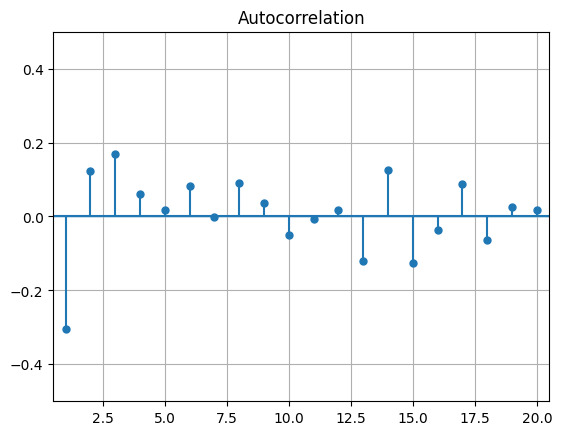

In [9]:
plot_acf(df.get_column(to_label).to_numpy(), missing = "drop", alpha = 0.95);
plt.grid()
plt.xlim((0.5, 20.5))
plt.ylim((-0.5, 0.5))

## (b) 標本偏自己相関

/home/work/.cache/pypoetry/virtualenvs/godaddy-3UyvmeC2-py3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


(-0.5, 0.5)

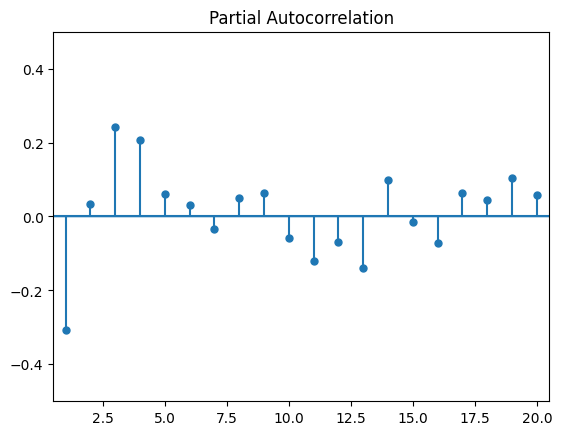

In [6]:
plot_pacf(df.get_column(to_label).to_numpy()[1:], alpha = 0.95);
plt.xlim((0.5, 20.5))
plt.ylim((-0.5, 0.5))

## AR(4) モデル

In [70]:
import statsmodels.api as sm

(-0.3, 0.3)

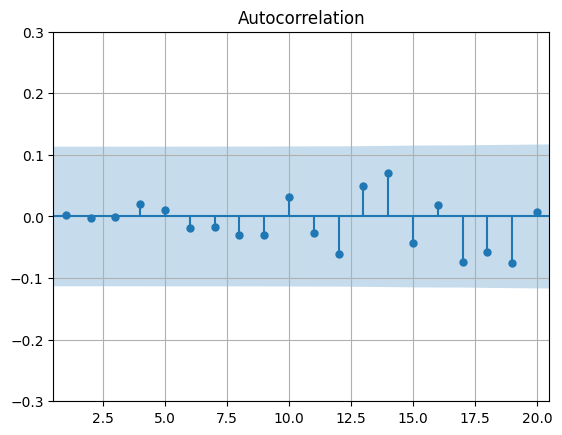

In [158]:
arima = sm.tsa.arima.ARIMA(df.get_column(to_label).to_numpy()[1:], order = (4,0,0)).fit()
plot_acf(arima.resid, lags = 20)
plt.xlim((0.5, 20.5))
plt.grid()
plt.ylim((-0.3, 0.3))

In [159]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(arima.resid, lags = 10)

,lb_stat,lb_pvalue
1,0.000815,0.977222
2,0.003037,0.998483
3,0.003756,0.999939
4,0.132518,0.997899
5,0.168907,0.999413
6,0.281111,0.999583
7,0.378456,0.999781
8,0.644024,0.999653
9,0.934324,0.999575
10,1.245650,0.999533


## ARMA(1, 2) モデル

(-0.3, 0.3)

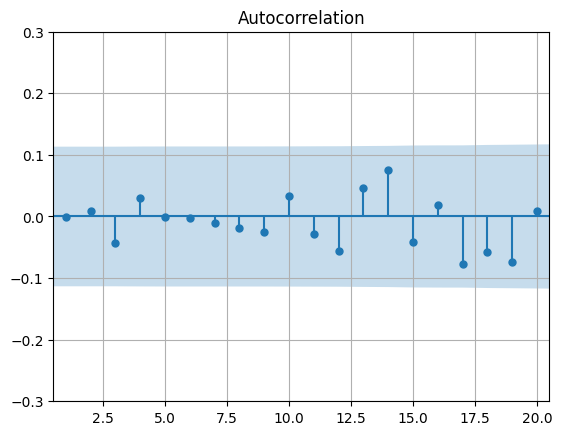

In [160]:
arima = sm.tsa.arima.ARIMA(df.get_column(to_label).to_numpy()[1:], order = (1,0,2)).fit()
plot_acf(arima.resid, lags = 20)
plt.xlim((0.5, 20.5))
plt.grid()
plt.ylim((-0.3, 0.3))

## 表2.3

In [76]:
import warnings
warnings.simplefilter("ignore")

## aic

In [94]:
data = [(4, 0), (0, 3), (1, 1), (2, 1), (1, 2), (2,2)]
lis = []
for p, q in data:
    arima = sm.tsa.arima.ARIMA(df.get_column(to_label).to_numpy()[1:], order = (p, 0 ,q)).fit()
    lis.append((p,q,arima.aic/len(df.get_column(to_label).to_numpy()[1:])))
    
print(sorted(lis,key = lambda x: x[2]))

[(4, 0, -5.969325340566843), (1, 2, -5.9681487868656395), (0, 3, -5.961814360172131), (2, 2, -5.961478423687096), (2, 1, -5.9235641536196235), (1, 1, -5.876220373084652)]


## BIC

In [96]:
data = [(4, 0), (0, 3), (1, 1), (2, 1), (1, 2), (2,2)]
lis = []
for p, q in data:
    arima = sm.tsa.arima.ARIMA(df.get_column(to_label).to_numpy()[1:], order = (p, 0 ,q)).fit()
    lis.append((p,q,arima.bic/len(df.get_column(to_label).to_numpy()[1:])))
    
print(sorted(lis,key = lambda x: x[2]))

[(1, 2, -5.914506874547942), (0, 3, -5.908172447854433), (4, 0, -5.904955045785606), (2, 2, -5.897108128905859), (2, 1, -5.869922241301926), (1, 1, -5.833306843230495)]


## 2.5(2)

In [118]:
arima = sm.tsa.arima.ARIMA(df.get_column(to_label).to_numpy()[1:], order = (4,0,0)).fit()
acorr_ljungbox(arima.resid, model_df = 4)

,lb_stat,lb_pvalue
1,0.040330,NaN
2,0.286749,NaN
3,0.289585,NaN
4,0.341665,NaN
5,0.588062,0.443170
6,0.620083,0.733417
7,0.967738,0.809058
8,7.032093,0.134202
9,8.288257,0.141048
10,10.746427,0.096537


In [125]:
arima = sm.tsa.arima.ARIMA(df.get_column(to_label).to_numpy()[1:], order = (1,0,2)).fit()
acorr_ljungbox(arima.resid, model_df = 3)

,lb_stat,lb_pvalue
1,0.044671,NaN
2,0.054937,NaN
3,1.409829,NaN
4,1.845719,0.174282
5,3.699678,0.157263
6,3.742478,0.290648
7,3.902674,0.419338
8,8.949047,0.111114
9,10.078812,0.121372
10,11.543724,0.116598


In [122]:
1 - stats.chi2.cdf(11.543724, 6)

0.07295700560727492

# 2.6

## データ準備

In [169]:
data ="./Data/arma.xls"
df = pd.read_excel(data)
df = pl.from_pandas(df)

<Axes: xlabel='date', ylabel='y1'>

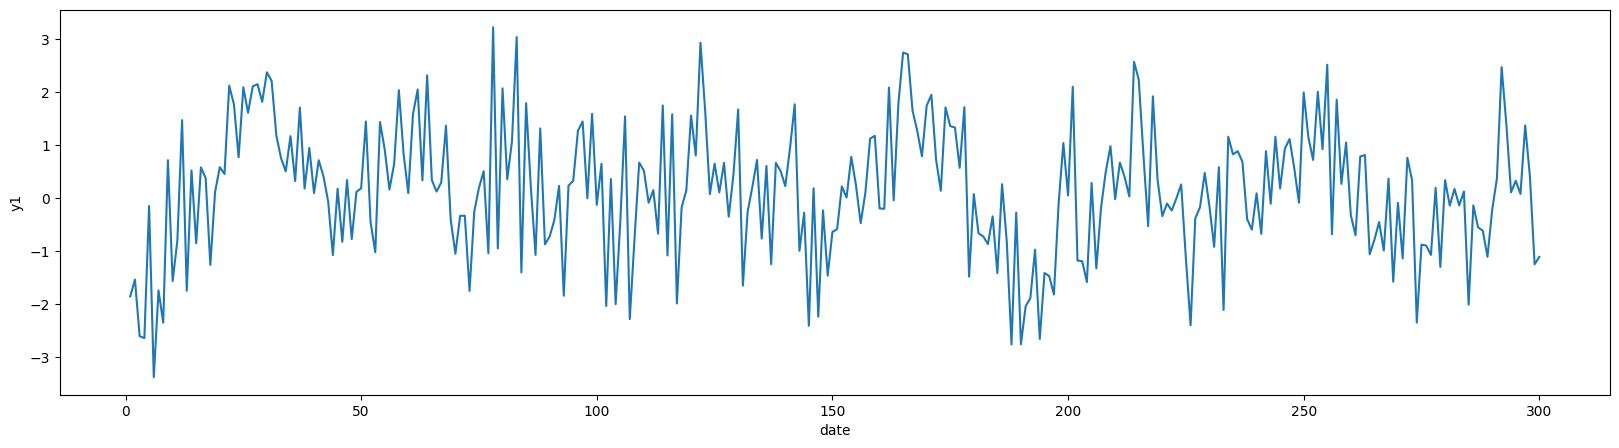

In [221]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (20, 5))

sns.lineplot(df, x ="date", y ="y1",ax = ax)

## (1)

In [170]:
df.head()

date,y1,y2,y3
i64,f64,f64,f64
1,-1.851416,-0.308855,0.228167
2,-1.534501,-0.527057,0.135259
3,-2.600396,-2.101098,1.428202
4,-2.636762,-2.586984,3.623135
5,-0.147869,-1.778408,4.435423


(0.5, 21.0)

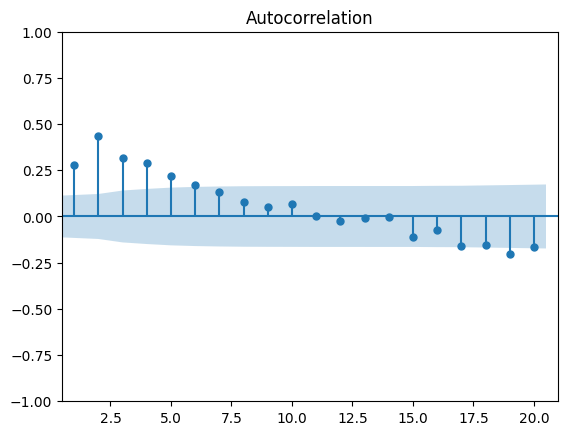

In [171]:
plot_acf(df.get_column("y1"),lags = 20);
plt.xlim((0.5, 21))

(0.5, 21.0)

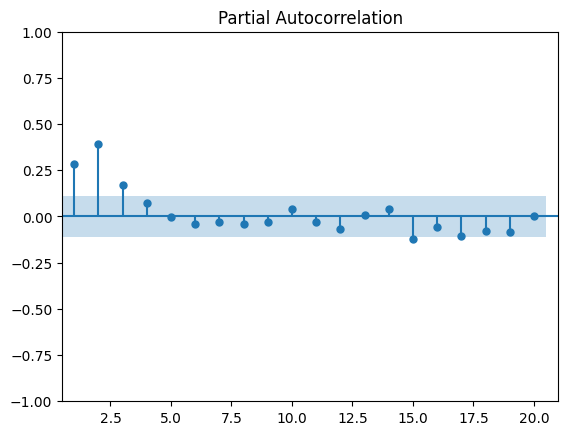

In [172]:
plot_pacf(df.get_column("y1"),lags = 20);
plt.xlim((0.5, 21))

In [181]:
ma_list = [0, 1, 2]
ar_list = [0, 1, 2]

In [208]:
lis = []
to_label = "y1"
for p in ar_list:
    for q in ma_list:
        arima = sm.tsa.arima.ARIMA(df.get_column(to_label).to_numpy(), order = (p, 0 ,q)).fit()
        lis.append((p,q,arima.aic))
    

In [209]:
for a,b,c in sorted(lis,key = lambda x: x[2]):
    print("p:",a,"\tq:",b,"\t aic",c,)

p: 1 	q: 2 	 aic 897.6217833071782
p: 2 	q: 1 	 aic 898.4772000394482
p: 2 	q: 2 	 aic 899.5750058751959
p: 2 	q: 0 	 aic 907.1793137592642
p: 1 	q: 1 	 aic 913.4618813776785
p: 0 	q: 2 	 aic 932.5121371209568
p: 1 	q: 0 	 aic 955.715825381667
p: 0 	q: 1 	 aic 966.5823567992056
p: 0 	q: 0 	 aic 978.5130601595704


In [202]:
from statsmodels.tsa import stattools

In [204]:
order_select = stattools.arma_order_select_ic(df.get_column(to_label).to_numpy(), max_ar=2, max_ma=2,  ic=['aic', 'bic'])

In [207]:
order_select["aic"]

,0,1,2
0,978.513060,966.582357,932.512137
1,955.715825,913.461881,897.621783
2,907.179314,898.477200,899.575006
